In [ ]:
# Scope: inglobe notebooks `test.ipynb`, `prove.ipynb`, `dataset_cleaning.ipynb`

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset Loading
Let's start by studying the quality of our dataset, and investigating some statistics. 

The data was taken from: ...

In [2]:
df = pd.read_csv('./dataset/recipes_82k.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82245 entries, 0 to 82244
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   category        18107 non-null  object
 1   cooking_method  82245 non-null  object
 2   cuisine         82230 non-null  object
 3   image           82245 non-null  object
 4   ingredients     82245 non-null  object
 5   prep_time       58630 non-null  object
 6   recipe_name     82245 non-null  object
 7   serves          82244 non-null  object
 8   tags            82011 non-null  object
dtypes: object(9)
memory usage: 5.6+ MB


In [4]:
# Drop the columns that are not useful for the analysis
df.drop(columns=['category', 'cuisine', 'image', 'prep_time', 'recipe_name', 'serves'], inplace=True)

Since we will focus on the recipe, column `cooking_method`, we drop the null values for this feature.

In [5]:
# Drop the rows with missing values in cooking_method
df.dropna(subset=['cooking_method'], inplace=True)
df = df[df['cooking_method'] != '[]']

In [6]:
df.head()

,cooking_method,ingredients,tags
0,['Set the racks in the middle and upper thirds...,"['1 tablespoons extra virgin olive oil', '1 cu...","Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,['Place the eggs in the air fryer basket and c...,"['4 large eggs', 'Salt (black pepper, everythi...","Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,"['Air Fryer directions:', 'Preheat air fryer t...","['olive oil spray', '4 about 5 ounce each salm...","Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['1/2 cup freshly grated Parmesan (not pre-gra...,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,['Cook potatoes in a large pot of salted water...,['3 1/2 pounds new potatoes (about 10 peeled a...,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


### Defrivation of the vocabulary for the whole corpus
Our corpus consists of the totality of the recipes, i.e., the whole `cooking_method` column. In the following cell we process this data t generate a vocabulary out of this corpus.

In [15]:
cooking_method = df['cooking_method']
type(cooking_method)

pandas.core.series.Series

In [20]:
def make_vocabulary(df):
    cooking_method = df['cooking_method']
    cooking_method = cooking_method.str.lower()
    cooking_method = cooking_method.str.replace('-', '') # fluffy-light -> fluffylight
    # remove all numbers and punctuations 
    cooking_method = cooking_method.str.replace(r'[^a-z\s]', ' ', regex=True)
    # remove multiple spaces
    cooking_method = cooking_method.str.replace(r'\s+', ' ')
    cooking_method = cooking_method.str.split()
    # remove duplicates (making it a set) and make it a list
    cooking_method = cooking_method.apply(lambda x: list(set(x)))
    cooking_method = cooking_method.explode() 
    
    cooking_method = cooking_method.value_counts()
    return cooking_method

In [23]:
cooking_method = make_vocabulary(df)
len(cooking_method)

24917

## Average length of recipes and ingredient list

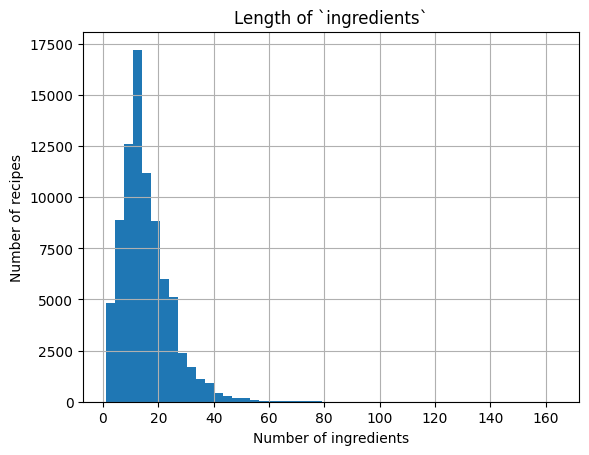

In [12]:
# histogram of length of ingredients
df['ingredients'].apply(lambda x: len(x.split(','))).hist(bins=50)
plt.xlabel('Number of ingredients')
plt.ylabel('Number of recipes')
plt.title('Length of `ingredients`')
plt.show()

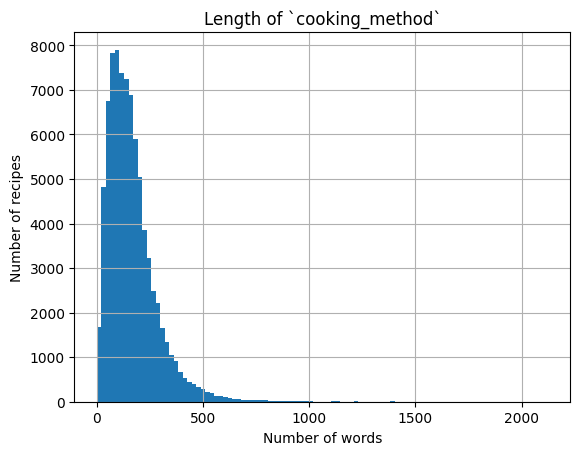

In [13]:
# same for cooking_method
df['cooking_method'].apply(lambda x: len(x.split(' '))).hist(bins=100)
plt.xlabel('Number of words')
plt.ylabel('Number of recipes')
plt.title('Length of `cooking_method`')
plt.show()

## Distribution of tags

In [ ]:
# TODO: studiare qualita delle ricette predette come veg: magari sono davvero veg anche se il ground truth è 0... il dataset non è perfetto